# Определение возраста покупателей

## Исследовательский анализ данных

Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50# < Перенесите сюда исследовательский анализ данных >

Узнаем размер выборки

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.shape)

(7591, 2)


In [3]:
display(labels.info())
display(labels.head(10))

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

features, target = next(train_gen_flow)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Found 7591 validated image filenames.


В датафрейме 2 столбца (object и int), в них соответственно хранятся фотографии и целевой признак - возраст (полные года).

Теперь построим график распределения возраста в выборке

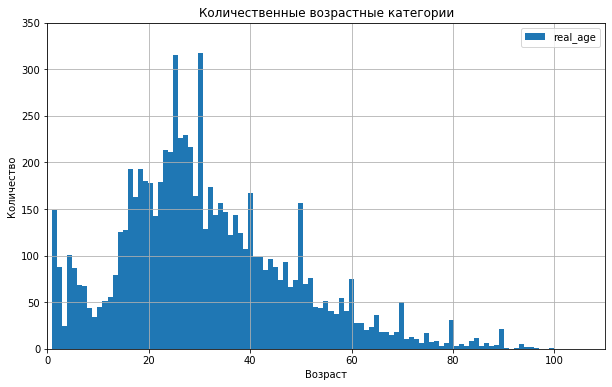

In [4]:
gr = labels.plot(kind = 'hist', 
                 figsize=(10,6), 
                 grid = True, 
                 xlim = (0,110), 
                 ylim = (0, 350), 
                 bins = 100)
gr.set_title('Количественные возрастные категории')
gr.set_xlabel('Возраст')
gr.set_ylabel('Количество')
plt.show()

Напечатаем 15 фотографий

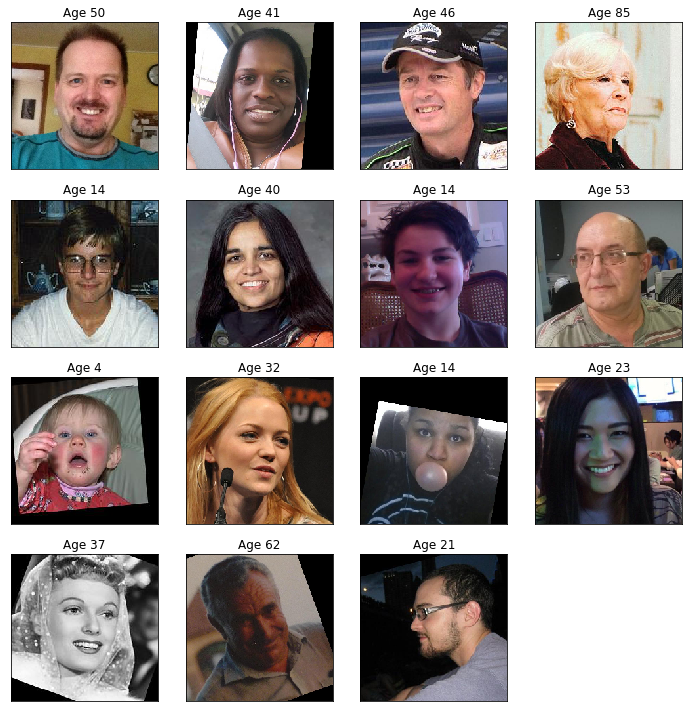

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.title('Age {}'.format(target[i]))
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Подводя итоги, можно сказать, что при обучении нейросети могут возникнуть проблемы с определением возрастов из-за недостатка количества фотографий людей определенных возрастных категорий. Так, например, самой распространенной возрастной категорией людей в нашем датасете являются люди 21-26 лет, с ними нейросеть справится довольно точно, но что можно сказать про категорию 60+? Мало примеров. 

В том числе, в датасете присутствуют фотографии различных форматов: обрезанные, повернутые, сдвинутые, черно-белые, в анфас и профиль и т.д. Не на паспорт, одним словом. С этим могут возникнуть дополнительные проблемы.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)        
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    validation_gen_flow = validation_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)        
    return validation_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    model.compile(
            optimizer=Adam(lr=0.0001),
            loss='mean_squared_error',
            metrics=['mae']
        )
    return model
 
def train_model(model, train_data, test_data, batch_size=32, epochs=5, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```
# Результат вывода на экран

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 113s - loss: 225.0046 - mae: 10.8209 - val_loss: 905.4265 - val_mae: 25.2606
Epoch 2/5
178/178 - 36s - loss: 62.4653 - mae: 5.9596 - val_loss: 766.7323 - val_mae: 22.6521
Epoch 3/5
178/178 - 37s - loss: 29.1996 - mae: 4.1733 - val_loss: 491.8102 - val_mae: 17.0641
Epoch 4/5
178/178 - 36s - loss: 19.0609 - mae: 3.3647 - val_loss: 137.8237 - val_mae: 8.8168
Epoch 5/5
178/178 - 36s - loss: 15.3685 - mae: 3.0161 - val_loss: 89.2538 - val_mae: 7.3762
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 89.2538 - mae: 7.3762
Test MAE: 7.3762


```

## Анализ обученной модели

Модель не переобучилась. <br>
Архитектура ResNet в 50 слоев отработала со средней абсолютной ошибкой 7.37, что меньше 8. Результат может считаться удовлетворительным. <br>
Итог также был получен при помощи алгоритма Adam с автоматическим подбором величины шага и скоростью обучения lr=0.0001.

**Вывод**

Пару слов о целесообразности внедрения модели в бизнес:<br>
    
Cупермаркет «Хлеб-Соль» собирается внедрить систему компьютерного зрения для обработки фотографий покупателей с целью закрытия двух потребностей:
 - Анализ покупок и предложений товаров, которые могут заинтересовать покупателей этой возрастной группы;
 - Контроль добросовестности кассиров при продаже алкоголя.
    
Итоговые значения, полученные после обучения модели, позволяют закрыть первую потребность, поскольку разброс в среднем в 7 лет в этом случае допустим. Однако, этого нельзя сказать про вторую потребность. Ведь по модели 24-летний парень может оказаться 17-летним подростком, который попадет под возрастные ограничения.